# Import statements

In [8]:
import os
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

2.17.0


# Model

First we load MobileNet model

In [27]:
def get_classes(n: int):
    dog_class_directory = os.getcwd()+'/dog_classes'
    return os.listdir(dog_class_directory)[:n]

# See the classes to train on
selected_classes = get_classes(10)

In [28]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

Add new top layers (decoder)

In [35]:
# Add new top layer
x = conv_base.output #the output of base model to go into top layers
x = GlobalAveragePooling2D()(x) #notsure
x = Dense(1024,activation='relu')(x) #dense layer, dafuq
preds = Dense(len(selected_classes),activation='softmax')(x) #final layer with softmax activation to make class predictions

# Specify model, combination of encoder and customised top layer
model = Model(inputs=conv_base.input, outputs=preds)

In [36]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


Define the training set and dataset. Both are of type `Dataloader`

In [37]:
dog_class_directory = os.getcwd()+'/dog_classes'

selected_classes = get_classes(10)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=8,
    subset = "training",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=8,
    subset = "validation",
    validation_split =0.2,
    shuffle=True,
    seed=123
)


Found 2385 files belonging to 10 classes.
Using 1908 files for training.
Found 2385 files belonging to 10 classes.
Using 477 files for validation.


Define the optimizer and train the model

In [39]:
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=20)

Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.3090 - loss: 1.9909 - val_accuracy: 0.3229 - val_loss: 1.9518
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.3944 - loss: 1.7466 - val_accuracy: 0.3333 - val_loss: 1.9010
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.4598 - loss: 1.5836 - val_accuracy: 0.3501 - val_loss: 1.8525
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5043 - loss: 1.4791 - val_accuracy: 0.3606 - val_loss: 1.8862
Epoch 5/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5491 - loss: 1.3828 - val_accuracy: 0.3878 - val_loss: 1.8104
Epoch 6/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.5636 - loss: 1.2808 - val_accuracy: 0.3920 - val_loss: 1.8288
Epoch 7/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.6004 - loss: 1.1992 - val_accuracy: 0.3941 - val_loss: 1.8818
Epoch 8/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.6252 - loss: 1.1354 - 

Plot `accuracy` against `epochs`.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


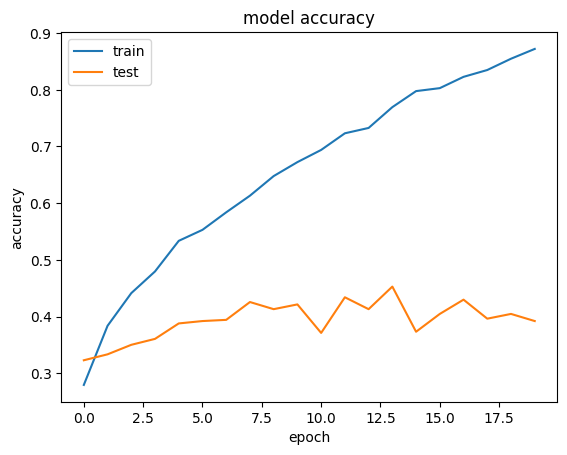

In [40]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Plot `loss` against `epochs`

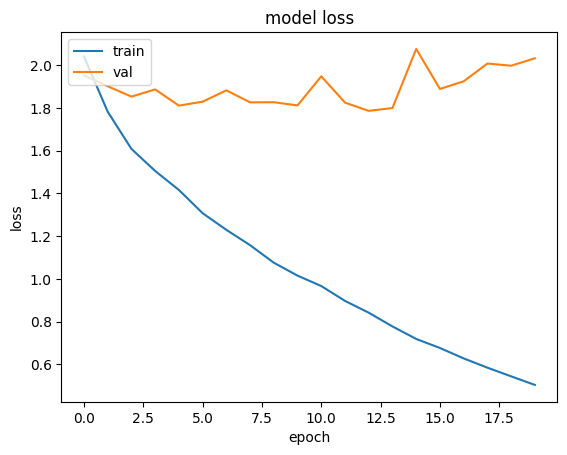

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()